In [3]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import seaborn as sns
import cebra
from cebra import CEBRA

from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels
from plotting import subplot_confusion_matrix
from constants import AUDIO_BLOCKS
from features.constants import Feature, MARKER_TO_FEATURE
from biomarkers import EEG_CHANEL_NAMES
from labels import get_raw_labels, get_label_means
from feature_extraction import EEG_BANDS

data_dir = "../CleandDataV2/"
random.seed(33)

In [4]:
import os

marker = "EEG"
num_slice_per_trial = 5

subject_list = []
valence_labels, arousal_labels, attention_labels = [], [], []
label_thresholds = []
for d in os.listdir(data_dir):    
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subject_data = load_data_from_dir(dir_name)
    vl, arl, atl = get_raw_labels(AUDIO_BLOCKS, subject_data, num_slice_per_trial)
    
    subject_list.append(d)
    valence_labels.append(vl)
    arousal_labels.append(arl)
    attention_labels.append(atl)
    label_thresholds.append(get_label_means(subject_data))

Loading ../CleandDataV2/2040 data...
Loading ../CleandDataV2/2013 data...
Loading ../CleandDataV2/2022 data...
Loading ../CleandDataV2/2025 data...
Loading ../CleandDataV2/2046 data...
Loading ../CleandDataV2/2041 data...
Loading ../CleandDataV2/2024 data...
Loading ../CleandDataV2/2012 data...
Loading ../CleandDataV2/2037 data...
Loading ../CleandDataV2/2001 data...
Loading ../CleandDataV2/2039 data...
Loading ../CleandDataV2/2006 data...
Loading ../CleandDataV2/2038 data...
Loading ../CleandDataV2/2007 data...
Loading ../CleandDataV2/2000 data...
Loading ../CleandDataV2/2009 data...
Loading ../CleandDataV2/2036 data...
Loading ../CleandDataV2/2031 data...
Loading ../CleandDataV2/2017 data...
Loading ../CleandDataV2/2028 data...
Loading ../CleandDataV2/2010 data...
Loading ../CleandDataV2/2026 data...
Loading ../CleandDataV2/2019 data...
Loading ../CleandDataV2/2021 data...
Loading ../CleandDataV2/2044 data...
Loading ../CleandDataV2/2043 data...
Loading ../CleandDataV2/2020 data...
L

In [5]:
import pickle

# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
len(marker_features)

41

In [6]:
IDX_MAP = {
    "hvha": 0,
    "hvla": 1,
    "nvha": 2,
    "nvla": 3,
    "lvha": "blue",
    "lvla": "steelblue",
}
target_names = ['hvha', 'hvla', 'nvha', 'nvla']

cat_labels = []
for idx, (v_thred, a_thred) in enumerate(label_thresholds):
    vc = [ 'hv' if l > v_thred else 'nv' for l in valence_labels[idx]]
    ac = [ 'ha' if l > a_thred else 'la' for l in arousal_labels[idx]]
    vac = [ IDX_MAP[vc[i]+ac[i]] for i in range(len(vc))]
    cat_labels.append(vac)
len(cat_labels)

41

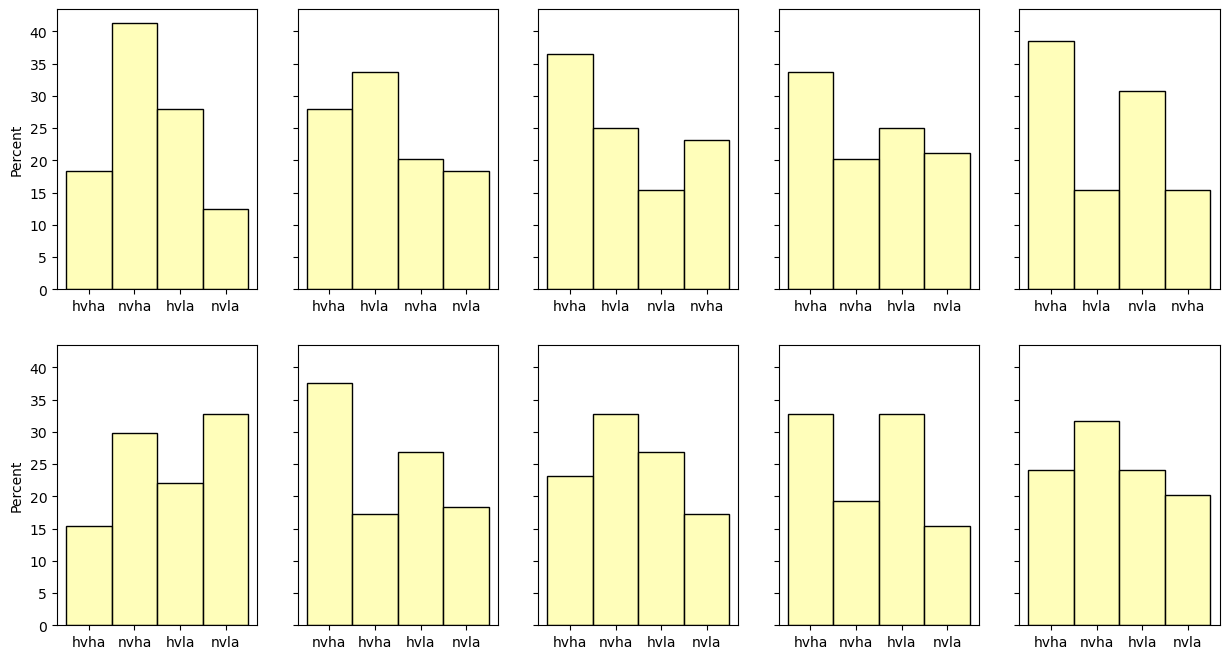

In [8]:
n = 2
hold_out_groups = [np.arange(n*k, n*k+n) for k in range(10)]

nrows = 2
ncol = 5
fig, axes = plt.subplots(
    nrows=nrows,
    sharey=True,
    ncols=ncol,
    figsize=(ncol * 3, nrows * 4),
)

for idx, ax in enumerate(axes.flat):
    all_labels = []
    for s in hold_out_groups[idx]:
        all_labels.extend(cat_labels[s])
    sns.histplot(data=[target_names[a]for a in all_labels], stat='percent', color='#fffea3', ax=ax)

In [ ]:
# All distribution
all_labels = []
for l in cat_labels:
    all_labels.extend(l)

sns.histplot(data=[target_names[a]for a in all_labels], stat='percent', color='#fffea3')

In [30]:
from model.embedding import get_embeddings
from sklearn.metrics import f1_score, accuracy_score

# CEBRA AND PCA hyper-parameters
OUTPUT_DIM = 6
MAX_HIDDEN_UNITS = 256


def _train_test_split(data, labels, val_indexes: list = []):
    train_indexes = list(set(range(len(labels))) - set(val_indexes))
    train_labels = np.array(labels)[train_indexes]
    train_data = np.array(data)[train_indexes]

    val_data = np.array(data)[val_indexes]
    val_label = np.array(labels)[val_indexes]
    return train_data, train_labels, val_data, val_label


# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    output_dim,
    max_hidden_units,
):
    from sklearn.neighbors import KNeighborsClassifier

    y_pred, all_embeddings = [], []
    for _, (train_data, train_labels, val_data, _) in enumerate(dataset):
        scaler = scaler.fit(train_data)
        embedding, val_embedding = get_embeddings(
            train_data=train_data, #preprocessing.normalize(train_data, axis=1, norm='l1'),
            val_data=val_data, # #preprocessing.normalize(val_data, axis=1, norm='l1'),
            train_labels=train_labels,
            use_pca=(method == "PCA"),
            out_dim=6 if method == "PCA" else output_dim,
            num_hidden_units=max_hidden_units,
        )
        all_embeddings.append(embedding)
        # 4. Train the decoder on training embedding and labels
        # train_true_cat = get_label_category(train_labels, label_type)
        decoder = KNeighborsClassifier()
        decoder.fit(embedding, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict_proba(val_embedding)
        y_pred.append(prediction)

    return y_pred, all_embeddings

def decode_marker_data(
    dataset_dict,
    method,
    filtered_channel: str = "",
    plot_roc: bool = False,
    plot_embed: bool = False,
):
    label_type = "valence-arousal"
    f1_score_data = {k: {} for k in dataset_dict.keys()}
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if channel != filtered_channel and len(filtered_channel) > 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                val_labels for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                OUTPUT_DIM,
                MAX_HIDDEN_UNITS,
            )
            ac_scores = [
                accuracy_score(
                    y_pred=np.argmax(val_pred_cat[i], axis=1), y_true=val_true_cat[i]
                )
                for i in range(len(val_pred_cat))
            ]
            accuracy[channel][f] = np.mean(ac_scores)

    return f1_score_data, accuracy

def get_all_spectral_features(feature_to_data: dict):
    all_spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return all_spetral_psd

In [28]:
dataset_dict = {k: {Feature.ALL_SPECTRAL.name: []} for k in marker_features[0].keys()}
for _, g in enumerate(hold_out_groups):
    train_data, train_labels, val_data, val_labels = _train_test_split(
        marker_features, cat_labels, g
    )
    print(train_data.shape, train_labels.shape, val_data.shape, val_labels.shape)
    # flatten the data
    train_channel_to_data = {k: [] for k in marker_features[0].keys()}
    for t in train_data:
        for channel, feature_to_data in t.items():
            train_channel_to_data[channel].append(
                get_all_spectral_features(feature_to_data)
            )

    val_channel_to_data = {k: [] for k in marker_features[0].keys()}
    for t in val_data:
        for channel, feature_to_data in t.items():
            val_channel_to_data[channel].append(
                get_all_spectral_features(feature_to_data)
            )
    for channel in dataset_dict.keys():
        dataset_dict[channel][Feature.ALL_SPECTRAL.name].append((
            np.concatenate(train_channel_to_data[channel]),
            train_labels.ravel(),
            np.concatenate(val_channel_to_data[channel]),
            val_labels.ravel(),
        ))

(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)
(39,) (39, 260) (2,) (2, 260)


In [31]:
def get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker: str, filtered_channel: str
):
    if marker != "EEG":
        return list(dataset_dict[marker].keys()), [
            accuracy[marker][f] for f in all_feature_name
        ]

    if len(filtered_channel) == 0:
        all_feature_name = list(dataset_dict.keys())
        mean_scores = [accuracy[c][Feature.ALL_SPECTRAL.name] for c in all_feature_name]
    else:
        all_feature_name = list(dataset_dict[filtered_channel].keys())
        mean_scores = [accuracy[filtered_channel][f] for f in all_feature_name]

    return all_feature_name, mean_scores

subject_accuracy_summary = {
    "channel": [],
    "cv_mean_score": [],
}
###CHANGE ME####
method = 'PCA'
filtered_channel = ""
plot_roc = False
plot_embeddings = False
###############

f1_score_data, accuracy = decode_marker_data(
    dataset_dict, method, filtered_channel, plot_roc, plot_embeddings
)

all_feature_name, mean_scores = get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker, filtered_channel
)

subject_accuracy_summary["channel"].extend(all_feature_name)
subject_accuracy_summary["cv_mean_score"].extend(mean_scores)

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary.head()

,channel,cv_mean_score
0,A,0.260769
1,B,0.253269
2,C,0.248654
3,D,0.259038


Text(0.5, 1.0, 'Group level EEG cv mean accuracy: PCA')

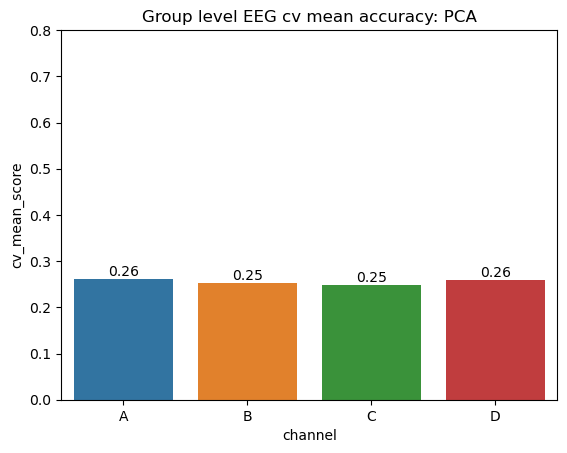

In [32]:
pp = sns.barplot(subject_accuracy_summary, x="channel", y="cv_mean_score")
pp.set_ylim((0, 0.8))
pp.bar_label(pp.containers[0], fontsize=10, fmt="%.2f")
pp.set_title(f'Group level EEG cv mean accuracy: {method}')